In [170]:
%%capture
!pip install datasets
!pip install contractions

In [171]:
# Standard Libraries
import logging
import re
import string
import random

# Data Manipulation and Analysis
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Natural Language Processing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
import contractions

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Datasets
from datasets import load_dataset, concatenate_datasets

Firstly, we download key components from the NLTK library, which are requireded for preprocessing tasks further in the code.

In [172]:
%%capture

nltk.download('wordnet') #lexical database of English words
nltk.download('punkt') #tokenizer for splitting text into a list of sentences
nltk.download('stopwords') #list of common words that do not contribute to the main meaning of text
nltk.download('averaged_perceptron_tagger') #part-of-speech tagger

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


The data is imported from 3 distinct datasets to ensure the diversity of input data.

In [173]:
%%capture
reddit_emotion_dataset = load_dataset("go_emotions", "raw")
reddit_emotion_dataset = reddit_emotion_dataset["train"]

twitter_dataset_01 = load_dataset("tweet_eval", "emotion")

twitter_dataset_02 = load_dataset("dair-ai/emotion", name="unsplit")

Let's investigate the datasets and provide some background information as well as links.
- **Reddit Dataset**: contains 58k Reddit comments, labelled for 27 emotions or Neutral by native English speakers from India. [Dataset Link](https://huggingface.co/datasets/google-research-datasets/go_emotions)
- **Twitter Dataset 1**: contains 5k tweets classified into 4 distinct emotions, data collected from [SemEval-2018 Task 1](https://aclanthology.org/S18-1001/). [Dataset Link](https://huggingface.co/datasets/cardiffnlp/tweet_eval)
- **Twitter Dataset 2**: contains 417k entries, classifying tweets into 6 emotions. Labeled using [unsupervised model](https://aclanthology.org/D18-1404/). [Dataset Link](https://huggingface.co/datasets/dair-ai/emotion)

All of the datasets contain only entries in English.

Let's visualize the sizes of the datasets.

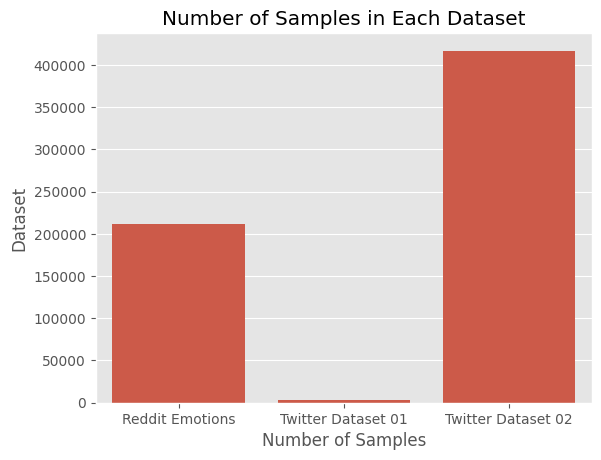

In [174]:
dataset_sizes = {
    "Reddit Emotions": len(reddit_emotion_dataset),
    "Twitter Dataset 01": len(twitter_dataset_01["train"]),
    "Twitter Dataset 02": len(twitter_dataset_02["train"])
}

sns.barplot(x=list(dataset_sizes.keys()), y=list(dataset_sizes.values()))
plt.title('Number of Samples in Each Dataset')
plt.xlabel('Number of Samples')
plt.ylabel('Dataset')
plt.show()

# Datasets Preprocessing

## Reddit Dataset Preprocessing

To focus on the attributes relevant to our emotion analysis, we simplify the Reddit dataset by removing several columns.

While some features such as "author" or "subreddit" may provide valuable information to the emotion analysis, for now the task is simplified, as these columns are more likely to introduce noisiness into data.

In [175]:
reddit_emotion_dataset = reddit_emotion_dataset.remove_columns(["link_id",
                                                                "author",
                                                                "id",
                                                                "parent_id",
                                                                "created_utc",
                                                                "subreddit",
                                                                "example_very_unclear",
                                                                "rater_id"
                                                                ])

To ensure clarity, let's focus only on entries with **distinctly labeled emotions**. This involves two key filtering steps:
- Removing entries **without any emotion** (where all emotions labeled as 0).
- Selecting entries that are labeled with **exactly one emotion**.


In [176]:
reddit_emotion_features = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

def filter_zero_emotions(entry):
    return any(entry[emotion] > 0 for emotion in reddit_emotion_features)

def filter_single_emotion(entry):
    return sum(entry[emotion] for emotion in reddit_emotion_features) == 1

print("Original number of rows:", len(reddit_emotion_dataset))

reddit_emotion_dataset = reddit_emotion_dataset.filter(filter_zero_emotions)
reddit_emotion_dataset = reddit_emotion_dataset.filter(filter_single_emotion)

print("Filtered number of rows:", len(reddit_emotion_dataset))


Original number of rows: 211225
Filtered number of rows: 171820


In [177]:
reddit_emotion_dataset = reddit_emotion_dataset.to_pandas()

As can be seen from the data visualization, there is a strong prevalence of "**neutral**" emotion in the data.

While imbalanced data may pose a challange, no action required until other two datasets are not observed, as they might balance the data.

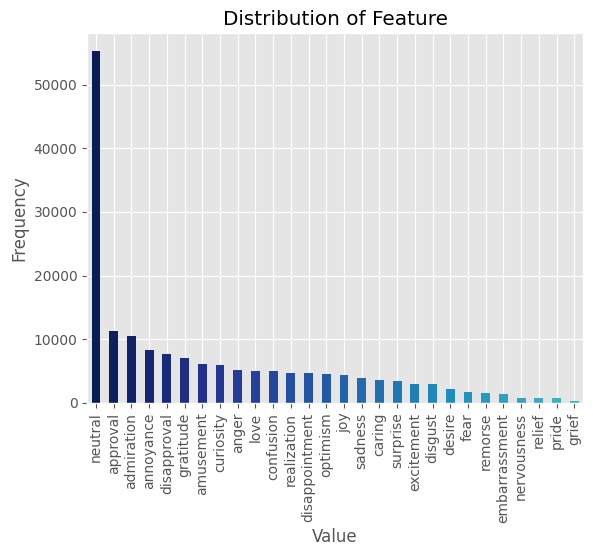

In [178]:
emotions_count = {}

for column in reddit_emotion_dataset.columns:
    if column != 'text':
        emotions_count[column] = (reddit_emotion_dataset[column] == 1).sum()

emotions_count = pd.Series(emotions_count)
emotions_count.sort_values(ascending=False, inplace=True)

plt.style.use('ggplot')
colors = plt.cm.YlGnBu(np.linspace(1, 0.5, len(emotions_count)))
emotions_count.plot(kind='bar', color=colors)

plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [179]:
reddit_emotion_dataset["label"] = pd.from_dummies(reddit_emotion_dataset[reddit_emotion_features])
reddit_emotion_dataset = reddit_emotion_dataset[["text", "label"]]

## Twitter Dataset Preprocessing

In [180]:
twitter_dataset_01 = concatenate_datasets([twitter_dataset_01["train"], twitter_dataset_01["validation"], twitter_dataset_01["test"]])
twitter_dataset_01

Dataset({
    features: ['text', 'label'],
    num_rows: 5052
})

Let's adjust categorical labels to be more descriptive in order to ease the dataset concatenation with the rest of the data and future visualization tasks.

In [181]:
twitter_df_01 = twitter_dataset_01.to_pandas()
twitter_df_01['label'] = twitter_df_01['label'].astype('category')
twitter_df_01['label'] = twitter_df_01['label'].cat.rename_categories({0: "anger", 1: "joy", 2: "optimism", 3: "sadness"})
twitter_df_01


,text,label
0,“Worry is a down payment on a problem you may ...,optimism
1,My roommate: it's okay that we can't spell bec...,anger
2,No but that's so cute. Atsu was probably shy a...,joy
3,Rooneys fucking untouchable isn't he? Been fuc...,anger
4,it's pretty depressing when u hit pan on ur fa...,sadness
...,...,...
5047,I need a sparkling bodysuit . No occasion. Jus...,joy
5048,@user I've finished reading it; simply mind-bl...,sadness
5049,shaft abrasions from panties merely shifted to...,anger
5050,All this fake outrage. Y'all need to stop 🤣,anger


As can be seen from the barchart below, the data is not balanced, with a clear prevalence of "anger". However, the number of entries is much smaller than that of other datasets, and therefore it can be assumed that this will not unbalance the data.

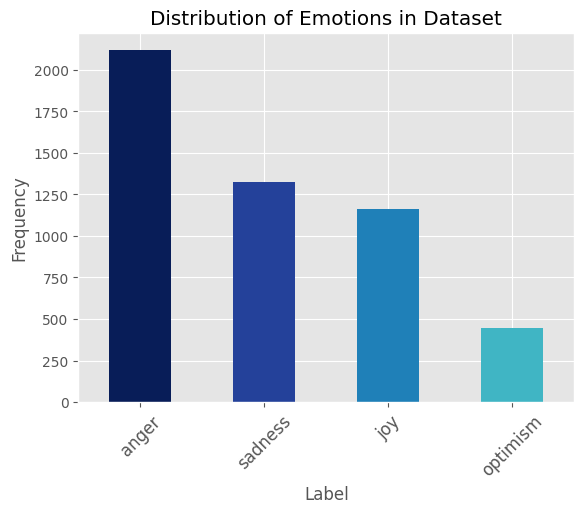

In [182]:
emotions_count = twitter_df_01['label'].value_counts()

plt.style.use('ggplot')
colors = plt.cm.YlGnBu(np.linspace(1, 0.5, len(emotions_count)))
emotions_count.plot(kind='bar', color=colors)

plt.title('Distribution of Emotions in Dataset')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(rotation=45, fontsize=12)
plt.show()

## Second Twitter Dataset Preprocessing

As in the example above, let us adjust categorical labels to be more descriptive.

In [183]:
twitter_df_02 = twitter_dataset_02["train"].to_pandas()
twitter_df_02['label'] = twitter_df_02['label'].astype('category')
twitter_df_02['label'] = twitter_df_02['label'].cat.rename_categories({0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"})

twitter_df_02

,text,label
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love
...,...,...
416804,that was what i felt when i was finally accept...,joy
416805,i take every day as it comes i m just focussin...,fear
416806,i just suddenly feel that everything was fake,sadness
416807,im feeling more eager than ever to claw back w...,joy


This dataset does not include a 'neutral' emotion and has a large number of entries, making it a valuable complement to the Reddit dataset.

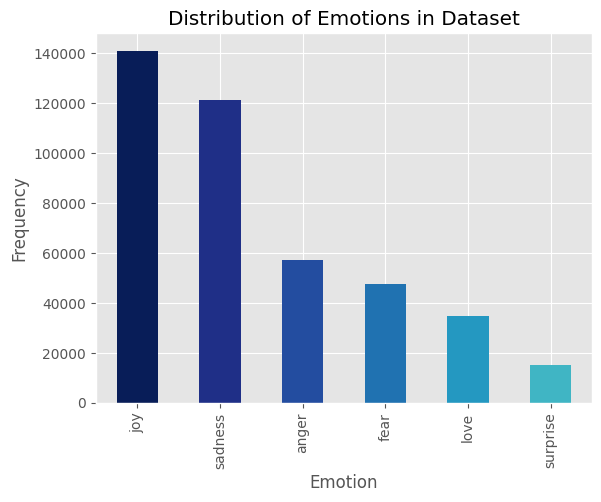

In [184]:
emotions_count = twitter_df_02['label'].value_counts()

# Plotting
plt.style.use('ggplot')
colors = plt.cm.YlGnBu(np.linspace(1, 0.5, len(emotions_count)))
emotions_count.plot(kind='bar', color=colors)

plt.title('Distribution of Emotions in Dataset')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

# Dataset Preparation for NLP

Firstly, let's combine all 3 datasets together.

In [185]:
emotion_df = pd.concat([twitter_df_01, twitter_df_02, reddit_emotion_dataset])
emotion_df

,text,label
0,“Worry is a down payment on a problem you may ...,optimism
1,My roommate: it's okay that we can't spell bec...,anger
2,No but that's so cute. Atsu was probably shy a...,joy
3,Rooneys fucking untouchable isn't he? Been fuc...,anger
4,it's pretty depressing when u hit pan on ur fa...,sadness
...,...,...
171815,"Well, I'm glad you're out of all that now. How...",joy
171816,Everyone likes [NAME].,love
171817,Well when you’ve imported about a gazillion of...,caring
171818,That looks amazing,admiration


## Visualizing and Balancing the Data

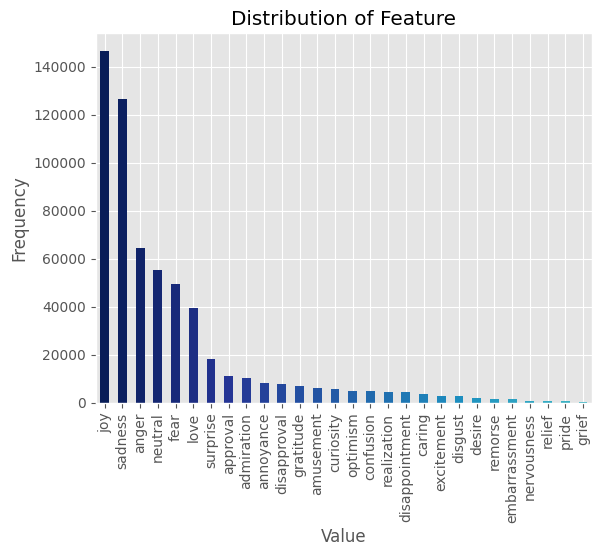

In [186]:
emotions_count = emotion_df['label'].value_counts()

plt.style.use('ggplot')
colors = plt.cm.YlGnBu(np.linspace(1, 0.5, len(emotions_count)))
emotions_count.plot(kind='bar', color=colors)

plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

The plot above highlights a strong prevalence of basic emotions such as 'joy', 'sadness', 'anger', 'fear', 'love', 'surprise', and 'neutral'.

Given our goal of providing a single, distinct emotion as the model output, we'll simplify our dataset to include only these core emotions. This approach should enhance the model's accuracy.



In [187]:
emotion_df = emotion_df[emotion_df.label.isin(["text", "joy", "sadness", "anger", "neutral", "fear", "love", "surprise"])]
emotion_df = shuffle(emotion_df).reset_index(drop=True)
emotion_df

,text,label
0,Probably just unfairly cherry picking things l...,neutral
1,i have a feeling it is going to be messy,sadness
2,I’m glad you had such a helpful person on the ...,joy
3,i am feeling more emotional than i thought i m...,sadness
4,"I’m rooting so hard for [NAME]. You can do it,...",neutral
...,...,...
500274,You die > mom will be sad,sadness
500275,i realise as i read on i am far from feeling f...,joy
500276,i am smart enough to warn my family when i am ...,anger
500277,i do know that when i m really on i feel amazing,surprise


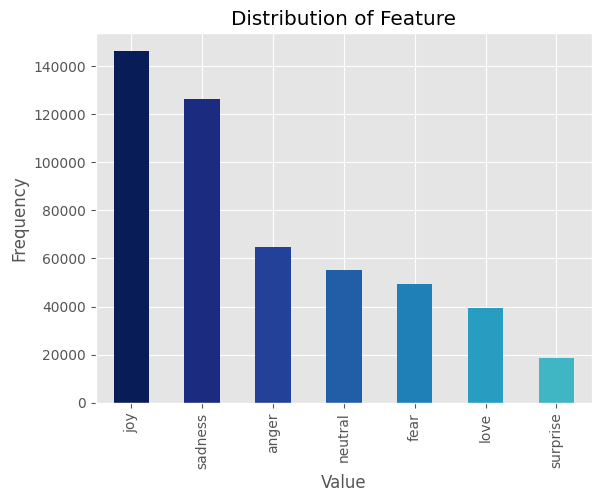

In [188]:
emotions_count = emotion_df['label'].value_counts()

plt.style.use('ggplot')
colors = plt.cm.YlGnBu(np.linspace(1, 0.5, len(emotions_count)))
emotions_count.plot(kind='bar', color=colors)

plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### Separating Train and Test

It is highly important to separate test and train data before the preprocessing to exclude the possibility of data leakage, especially in the case of random oversampling.

In [189]:
test_df = emotion_df.sample(7500)
emotion_df = emotion_df.drop(test_df.index)
test_df.reset_index(inplace=True, drop=True)

### Undersampling

In order to achieve a balanced dataset, it is first necessary to employ an undersampling technique. As the data frame has already been shuffled in the previous step, let's simply retain the first 40k samples.

The 40,000 sample size has been chosen as it is both sufficient for the model to be trained on and minimises the need for oversampling techniques in next steps.

In [190]:
SAMPLES_PER_CLASS = 40000
emotion_df = emotion_df.groupby('label').apply(lambda x: x.sample(SAMPLES_PER_CLASS) if len(x) > SAMPLES_PER_CLASS else x)
emotion_df = emotion_df.sample(frac=1).reset_index(drop=True)
emotion_df = emotion_df.dropna()

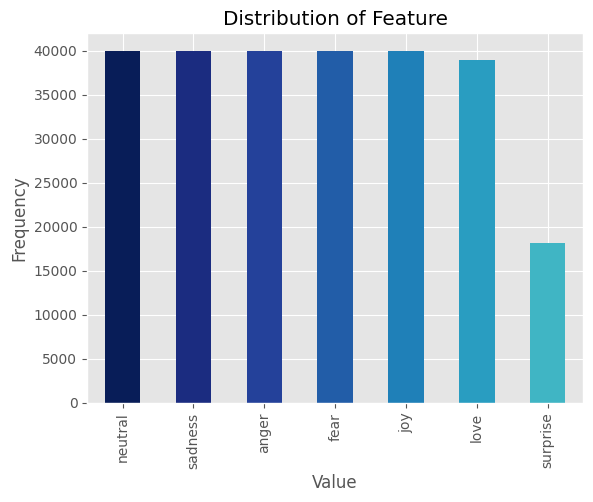

In [191]:
emotions_count = emotion_df['label'].value_counts()

plt.style.use('ggplot')
colors = plt.cm.YlGnBu(np.linspace(1, 0.5, len(emotions_count)))
emotions_count.plot(kind='bar', color=colors)

plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### Oversampling

In [192]:
all_surprise = emotion_df.loc[emotion_df['label'] == "surprise"]
all_surprise.reset_index(inplace=True, drop=True)

for i in range(5):
  random_sample = all_surprise.sample(4000)
  emotion_df = pd.concat([emotion_df, random_sample])

In [193]:
emotion_df.reset_index(inplace=True, drop=True)

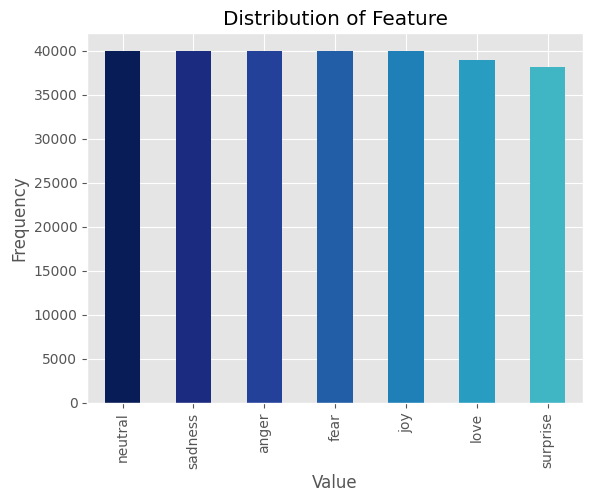

In [194]:
emotions_count = emotion_df['label'].value_counts()

plt.style.use('ggplot')
colors = plt.cm.YlGnBu(np.linspace(1, 0.5, len(emotions_count)))
emotions_count.plot(kind='bar', color=colors)

plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## Preprocess Text

Firstly, it is important to lowercase the data.

In [195]:
emotion_df['text']=emotion_df['text'].str.lower()

Expanding contractions: won't -> will not, i'll -> i will, etc

In [196]:
def expand_contractions(data):
  return contractions.fix(data)

emotion_df['text']= emotion_df['text'].apply(lambda x: expand_contractions(x))

A function to remove stopwords is prepared, but was not implemented following the tests, which demonstrated that the accuracy was slightly better without it.

In [197]:
retain_words = {'not', 'no', 'nor', "don't", "aren't", "couldn't", "didn't", "doesn't", "hadn't",
                "hasn't", "haven't", "isn't", "mustn't", "needn't", "shan't", "shouldn't", "wasn't",
                "weren't", "won't", "wouldn't", "but", "didn", "mightn't", "against", "wouldn", "weren", "aren",
                "ain", "won", "t", "s", "needn", "couldn", "d", "doesn", "don",  'should', "should've",'shouldn', "over"}

stopwords_set = set(stopwords.words('english')) - retain_words

In [198]:
def remove_stopwords(data):
  data = re.split(r"(\s+)", data)
  output_data = ""
  for word in data:
    if word in stopwords_set:
      output_data = output_data
    else:
      output_data += word

  return output_data.strip()

- Remove all entries starting with @
- Remove all numbers
- Remove all apostrophs '
- Remove all URLs

In [199]:
def cleaning_username(data):
    return re.sub('@[^\s]+', '', data)

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

def cleaning_apostrophs(data):
    return re.sub('\'', '', data)

def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))','', data)

def clean_punctuations(data):
    punct_to_remove = string.punctuation.replace('!', '').replace('?', '')
    pattern = f"[{re.escape(punct_to_remove)}]"

    data = re.sub(pattern, '', data)
    data = data.replace('!', ' !').replace('?', ' ?')

    return data

emotion_df['text']=emotion_df['text'].apply(lambda x: cleaning_username(x))
emotion_df['text']=emotion_df['text'].apply(lambda x: cleaning_numbers(x))
emotion_df['text']=emotion_df['text'].apply(lambda x: cleaning_URLs(x))
emotion_df['text']=emotion_df['text'].apply(lambda x: cleaning_apostrophs(x))

emotion_df['text'] = emotion_df['text'].str.replace(r'\s+', ' ', regex=True)
emotion_df['text']= emotion_df['text'].apply(lambda x: clean_punctuations(x))


In [200]:
emotion_df

,text,label
0,i was feeling a little delicate so i got a chi...,love
1,it is rare to see a wholesome post here nice t...,neutral
2,i never thought this day would come and yet i ...,sadness
3,i stop and pay attention to it i feel somewhat...,sadness
4,i wish someone would own me i so want to feel ...,love
...,...,...
277080,i still feel a little weird telling people abo...,surprise
277081,i feeling so dazed and confused,surprise
277082,i had a feeling i was going to be less than im...,surprise
277083,i feel like i am in such a strange place in life,surprise


### Separate features and target

In [201]:
X_train = emotion_df['text']
y_train = emotion_df.drop('text', axis=1)

emotion_df['text'] = X_train
emotion_df['label'] = y_train

In [202]:
X_test = test_df['text']
y_test = test_df.drop('text', axis=1)

In [203]:
encoder = OneHotEncoder(sparse=False)

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

y_train = pd.DataFrame(y_train, columns=encoder.get_feature_names_out())
y_test = pd.DataFrame(y_test, columns=encoder.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Tokenization

The length of the vocabulary was chosen to be 20000, as most adult native speakers have vocabulary range from 20k to 35k, therefore this amount should be sufficient to capture the  sentence.

In [204]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens = 20000,
                                                    output_sequence_length = 200,
                                                    standardize="lower")
vectorize_layer.adapt(X_train)

example_texts = ["Hello world ! ?"]
vectorized_texts = vectorize_layer(example_texts)
print(vectorized_texts)

tf.Tensor(
[[2266  204   65  100    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  

In [205]:
X_train = vectorize_layer(X_train)
X_test = vectorize_layer(X_test)

# Model Development

In [206]:
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=5,
                                        restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5, verbose=1)

In [207]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(
      input_dim=20000,
      output_dim=100,
      mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.4)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.4)),
  tf.keras.layers.Dense(64),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Dense(7, activation='softmax')
])

In [208]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [209]:
history = model.fit(X_train, y_train, batch_size=64, epochs=15, validation_split=0.25, verbose=1, callbacks=[early_stopping_callback, reduce_lr])

Epoch 1/15
3248/3248 [==============================] - 164s 45ms/step - loss: 0.5070 - accuracy: 0.8356 - precision_2: 0.8881 - recall_2: 0.7897 - val_loss: 0.3247 - val_accuracy: 0.8952 - val_precision_2: 0.9089 - val_recall_2: 0.8842 - lr: 0.0010
Epoch 2/15
3248/3248 [==============================] - 119s 37ms/step - loss: 0.2766 - accuracy: 0.9032 - precision_2: 0.9185 - recall_2: 0.8871 - val_loss: 0.3104 - val_accuracy: 0.8993 - val_precision_2: 0.9110 - val_recall_2: 0.8913 - lr: 0.0010
Epoch 3/15
3248/3248 [==============================] - 115s 35ms/step - loss: 0.2448 - accuracy: 0.9100 - precision_2: 0.9234 - recall_2: 0.8966 - val_loss: 0.3013 - val_accuracy: 0.9038 - val_precision_2: 0.9115 - val_recall_2: 0.8986 - lr: 0.0010
Epoch 4/15
3248/3248 [==============================] - 116s 36ms/step - loss: 0.2268 - accuracy: 0.9145 - precision_2: 0.9251 - recall_2: 0.9037 - val_loss: 0.2811 - val_accuracy: 0.9061 - val_precision_2: 0.9138 - val_recall_2: 0.8994 - lr: 0.0010


In [210]:
accr1 = model.evaluate(X_test, y_test) #we are starting to test the model here


235/235 [==============================] - 3s 14ms/step - loss: 0.2801 - accuracy: 0.8948 - precision_2: 0.9037 - recall_2: 0.8881


<Axes: >

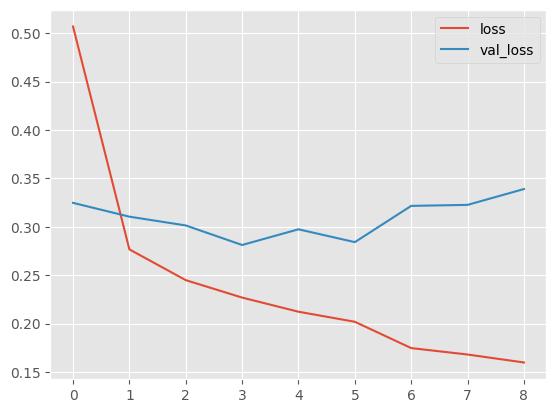

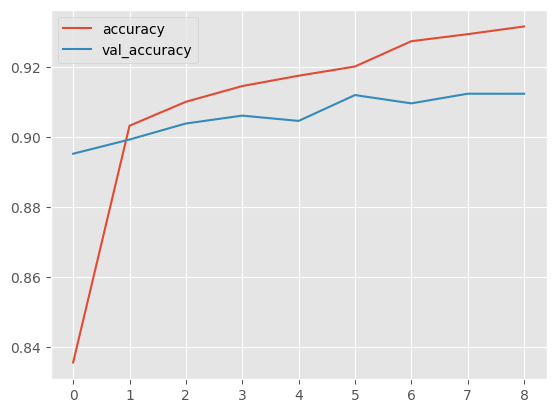

In [211]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [212]:
model.save("/content/my_model.keras")

In [213]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 128)         84480     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_2 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                      

In [218]:
text = "We had such a wonderful time at the beach today"
sequences = vectorize_layer(text)
sequences = tf.expand_dims(sequences, axis=0)  # Add batch dimension
sequences

<tf.Tensor: shape=(1, 200), dtype=int64, numpy=
array([[  72,   62,  180,    7,  504,   58,   33,    5, 1847,  146,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [219]:
prediction = model.predict(sequences)
predicted_index = np.argmax(prediction)

predicted_label = y_train.columns[predicted_index]
print(predicted_label)
print(prediction)

1/1 [==============================] - 0s 21ms/step
label_joy
[[0.00852457 0.00149019 0.83859766 0.00320179 0.14486349 0.00243792
  0.00088438]]


In [216]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(true_classes, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

235/235 [==============================] - 2s 8ms/step
[[8.96896897e-01 2.80280280e-02 4.00400400e-03 1.00100100e-03
  6.60660661e-02 4.00400400e-03 0.00000000e+00]
 [5.23560209e-03 8.84816754e-01 1.30890052e-03 0.00000000e+00
  2.87958115e-02 1.30890052e-03 7.85340314e-02]
 [6.83060109e-03 1.36612022e-03 8.78415301e-01 7.51366120e-02
  3.00546448e-02 0.00000000e+00 8.19672131e-03]
 [5.06756757e-03 0.00000000e+00 0.00000000e+00 9.62837838e-01
  3.04054054e-02 1.68918919e-03 0.00000000e+00]
 [1.08974359e-01 6.41025641e-03 7.69230769e-03 1.41025641e-02
  8.55128205e-01 3.84615385e-03 3.84615385e-03]
 [2.85563194e-02 1.58646219e-02 3.17292438e-03 5.28820730e-04
  2.80274987e-02 9.22792173e-01 1.05764146e-03]
 [2.51798561e-02 0.00000000e+00 7.19424460e-03 0.00000000e+00
  1.47482014e-01 0.00000000e+00 8.20143885e-01]]


<Figure size 1500x1500 with 0 Axes>

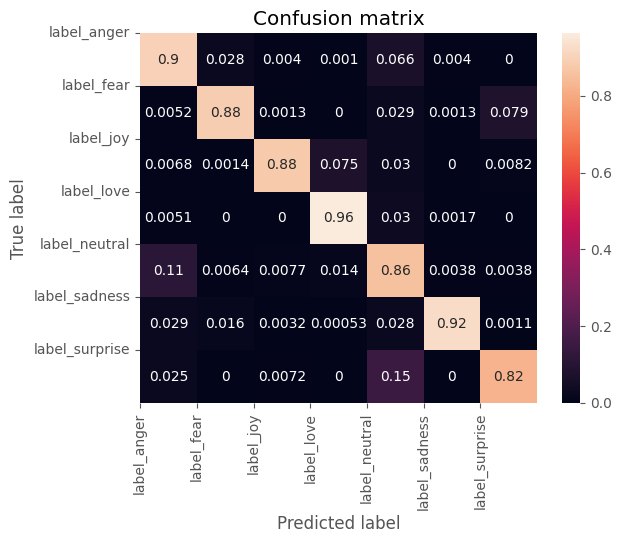

<Figure size 1500x1500 with 0 Axes>

In [217]:
classes = y_train.columns

sns.heatmap(cm, annot=True)
plt.title('Confusion matrix')

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes, rotation=0)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.figure(figsize=(15, 15))